# Problem Set 5

Due in your git fork by 11:59pm Pacfic time on Monday, December 4th.

All problems have equal weight.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys

## Problem 1: Energy levels

For this exercise we will follow the discussion of the energy levels in Chapter 9.2.2 and 9.3. 

(a) Start by assuming the finite square well with depth 83 MeV and radius 2 fm, as in Eqn. 9.5. Use the mass of the proton, as in Eqn. 9.8. Use the Numerov method to solve for the allowed energies in the well. 

In [59]:
def V(x, a, depth):            #calculates the potiental energy at a given position
    if np.abs(x) <= a:         #checks if position is in the well
        v = depth              #sets the energy to the depth of the well
    else:
        v = 0                  #if outside the well sets potentail to 0
    return v


def k_sqrd(x, e, const, a, depth):   
    k_sq = np.array([])
    for x_val in x:
        k_sq = np.append(k_sq, const * (e - V(x_val, a, depth)))    #calculates all the k_sqrd values for the energy
    return k_sq


def numerov_alg(wf, k2, h):
    b = (h ** 2) / 12
    if h > 0:                           #checks side of the well the particle is on
        for i in range(len(wf) - 1):
            if i == 0 or i == 1:        #doesn't overwrite the initial values
                continue
            else:
                wf[i + 1] = (2 * wf[i] * (1 - 5 * b * k2[i]) - (1 + b * k2[i - 1]) * wf[i - 1]) / (1 + b * k2[i + 1])
    else:
        for i in range(len(wf) - 1):    #works for other side of the well
            index = -(1 + i)            #needs to work from right to left
            if index == -1 or index == -2: #doesn't overwrite the initial values
                continue
            else:
                wf[index - 1] = (2 * wf[index] * (1 - 5 * b * k2[index]) - (1 + b * k2[index + 1]) * wf[index + 1]) / (
                            1 + b * k2[index - 1])


def numerov(depth, radius, eps):
    
    #controls#
    h = .001
    tmohbs = .0483  # 2m/hbar^2
    matching_point = radius

    x = np.array([])
    i = 0
    xl = -2 * radius    #sets left edge
    match_index = 0
    while xl < 2 * radius:
        xl = (-2 * radius) + i * h          #builds array using h step sizes
        if xl == np.round(float(matching_point), 3):  #finds a match point using the eps of h
            match_index = i

        x = np.append(x, xl)
        i += 1

    left_wf = np.zeros(len(x))        #creates list for left side
    left_wf[1] = -.00001              #sets initial value for left side

    right_wf = np.zeros(len(x))       #creates list for right side
    right_wf[-2] = -.00001            #sets initial value for right side

    wavefunction = np.array([])

    max_trials = 100                  #sets max trial size
    trial_step = 0
    sign = [-1,-1]
    erange = np.arange(depth,4,2)     #sets large steps of e vals to test over
    e_min = erange[0]
    e_max = erange[1]
    e = e_min
    allowed_e = []
    wavefunctions = []

    for i in range(len(erange)-1):
        k_sq = k_sqrd(x, e, tmohbs, radius, depth)  #calcs ksqrd for the given e value
        numerov_alg(left_wf, k_sq, h)               #calcs leftside wavefunction
        numerov_alg(right_wf, k_sq, -h)             #calcs rightside wavefunction
        left = (left_wf[match_index+1] - left_wf[match_index-1])/(2*h) / left_wf[match_index]
        right = (right_wf[match_index+1] - right_wf[match_index-1])/(2*h) / right_wf[match_index]
        delta_e = (left - right) / (left + right)   #checks the difference between the wavefunctions
        #check where flip from pos to neg and look in that zone
        sign[1] = np.sign(delta_e)                  #finds sign of difference is wavefunctions at matchpoint
        if sign[0] == -1 and sign[1] == 1:          #only this flip contains a allowed energy value
            e_min = erange[i-2]                     #sets range for better investigation
            while trial_step < max_trials:
#                 print(e, e_max, e_min)
                if abs(delta_e) < eps:              #checks if difference is within tolerance 
                    if len(allowed_e) > 0 and round(allowed_e[-1],4) == round(e,4): #prevents double count
                            break
                    wavefunction = np.append(left_wf[0:match_index], right_wf[match_index:]) #adds allowed wavefunction to list
                    allowed_e = np.append(allowed_e, e)     #records allowed energy value
                    right_wf[-2] *= -1              #acounts for even odd flip 
                    wavefunctions = np.append(wavefunctions, wavefunction)
                    break
                else:
                    #bisection method for finding a more precise value for e
                    if delta_e < 0:
                        e_min = e
                    else:
                        e_max = e
                    e = (e_min + e_max) / 2
                    trial_step += 1
                    sign[0] = sign[1]
                    k_sq = k_sqrd(x, e, tmohbs, radius, depth)
                    numerov_alg(left_wf, k_sq, h)
                    numerov_alg(right_wf, k_sq, -h)
                    left = (left_wf[match_index + 1] - left_wf[match_index - 1]) / (2 * h) / left_wf[match_index]
                    right = (right_wf[match_index + 1] - right_wf[match_index - 1]) / (2 * h) / right_wf[match_index]
                    delta_e = (left - right) / (left + right)
        e = (erange[i + 1] + erange[i]) / 2    #looks in next slot
        trial_step = 0
        sign[0] = sign[1]
    wavefunctions = np.reshape(wavefunctions, (len(allowed_e),len(x)))  #fixes wavefunctions to be correct size
    return wavefunctions, x, allowed_e


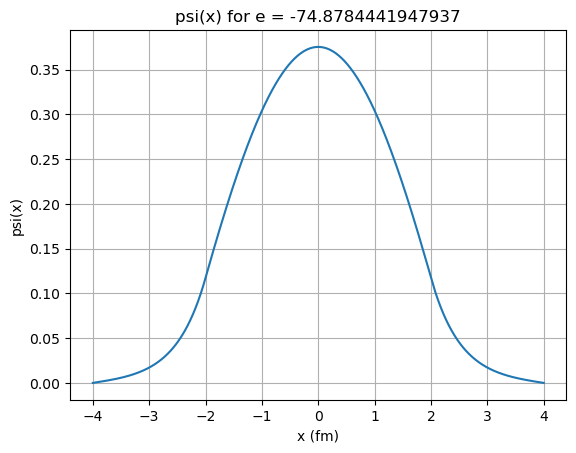

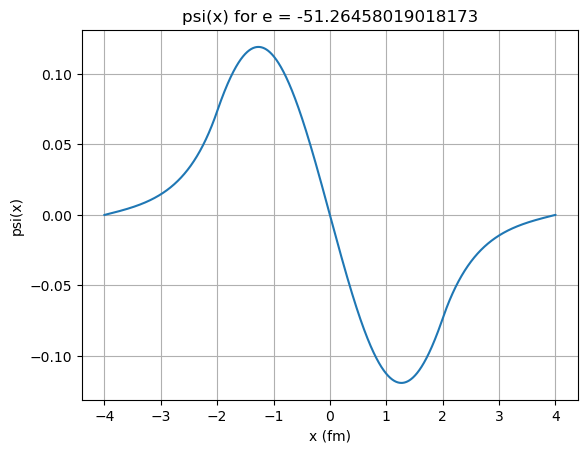

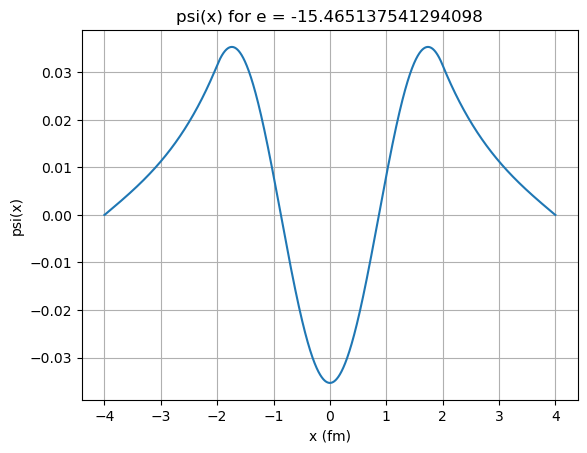

Allowed Energies:
-74.8784441947937 MeV
-51.26458019018173 MeV
-15.465137541294098 MeV


In [61]:
%matplotlib inline
#controls
depth = 83
radius = 2
eps = 1e-8
positions = []

wavefunctions, position, e = numerov(-depth, radius, eps)
for i in range(len(wavefunctions)):
    plt.plot(position, wavefunctions[i])
    plt.xlabel('x (fm)')
    plt.ylabel('psi(x)')
    plt.title(f'psi(x) for e = {e[i]}')
    plt.grid(True)
    plt.show()
    
print('Allowed Energies:')
for energy in e:
    print(f'{energy} MeV')
    

(b) Plot the allowed wave functions on the same figure as the potential, as in Figure 9.1. (You will have to scale one of them to make them both fit.) Draw a horizontal line to represent each of the allowed energies. 

[-74.87844419 -51.26458019 -15.46513754]


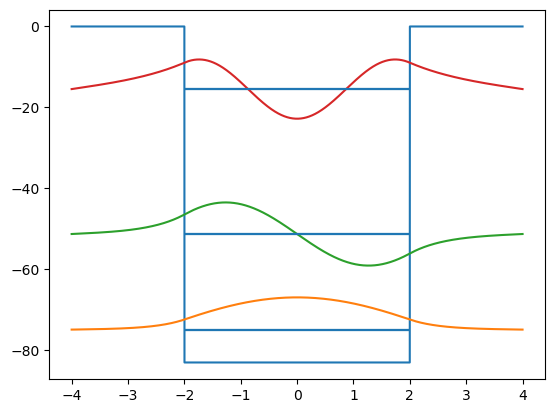

In [62]:
print(e)

def well(x,a):  #creates data for the well
    wellvalue= np.zeros(len(x))
    for i in range(len(x)):
        if abs(x[i])<a:
            wellvalue[i] = -83
    return wellvalue

wellval = well(position,2)
plt.plot(position,wellval)

for i in range(len(wavefunctions)):
    norm = 1/np.sqrt(np.sum(np.abs(wavefunctions[i])**2))  #calculates a normal for each wavefunction
    plt.plot(position,norm*wavefunctions[i]*400+e[i])      #plots normalized wavefunctions
    plt.hlines([e], -2,2)
    
plt.show()

(c) Check to see how the bound-state energies change when the radius of the well changes. Start by increasing the radius by a factor of 2.

For radius = 0.5
Energies: [-18.38745117]



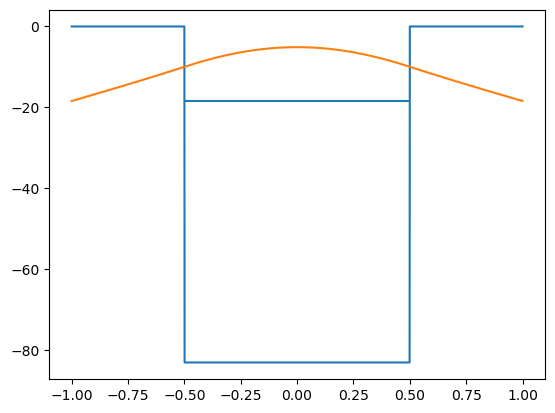

For radius = 1
Energies: [-60.24298096]



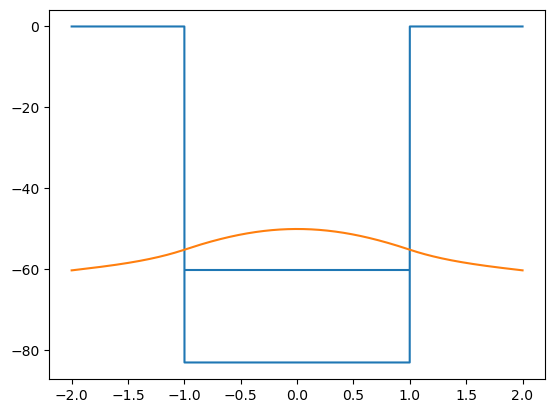

For radius = 2
Energies: [-74.87844849 -51.26452637 -15.46520996]



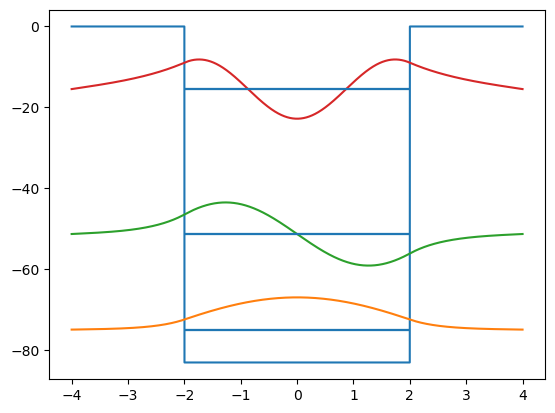

For radius = 4
Energies: [-80.48010254 -72.95656586 -60.55307007 -43.54614258 -22.6078186
  -0.39472961]



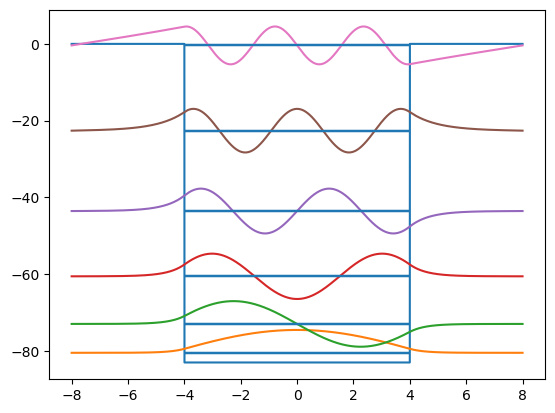

In [74]:
for radi in [.5,1,2,4]:
    depth = 83
    eps = 1e-5
    energies = []
    positions = []
    level = 0
    wavefunction, position, energies, = numerov(-depth, radi, eps)
    print(f"For radius = {radi}")
    print('Energies:', energies)
    print()
    
    wellval = well(position,radi)
    plt.plot(position,wellval)

    for i in range(len(wavefunction)):
        norm = 1/np.sqrt(np.sum(np.abs(wavefunction[i])**2))
        plt.plot(position,norm*wavefunction[i]*400+energies[i])
        plt.hlines([energies], -radi,radi)

    plt.show()

## Problem 2: 3-body problems

The Pythagorean version of the Euler 3-body problem has 3 masses at the corners of a 3-4-5 right triangle.

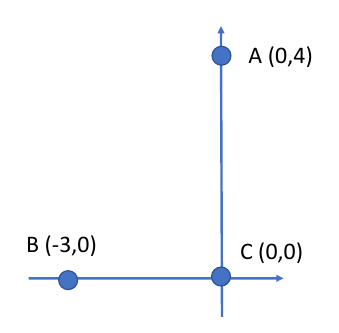

The force on each mass $m_{i}$ is the sum of gravitational forces from the other masses:

$$\vec{F}_{i} = -G\sum_{j\neq i}m_{i}m_{j}\frac{\vec{r}_i-\vec{r}_j}{|\vec{r}_i-\vec{r}_j|^3}$$

With units arranged so that G = 1, the masses have values $m_{A} = 3$, $m_{B} = 4$, and $m_{C} = 5$, and they are at rest at $t = 0$ as shown in the figure.

(a) Find the motion of the system over the interval $t = 0$ to $t = 10$. Use python libraries to solve the ODE's.  (If you have time, try to use the animation functions.) 

[-0.096  -0.4405]


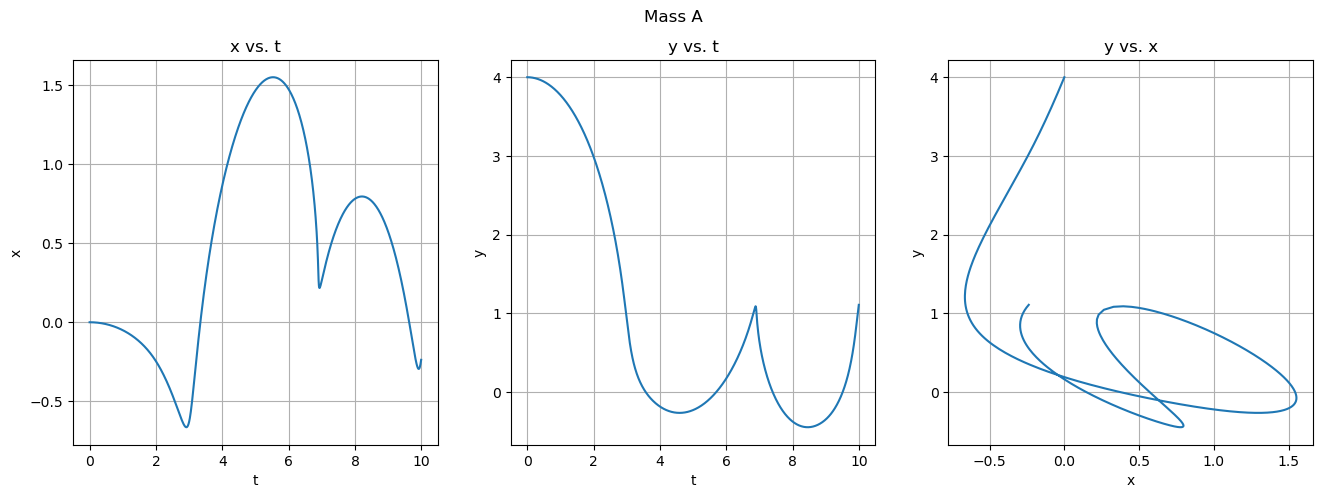

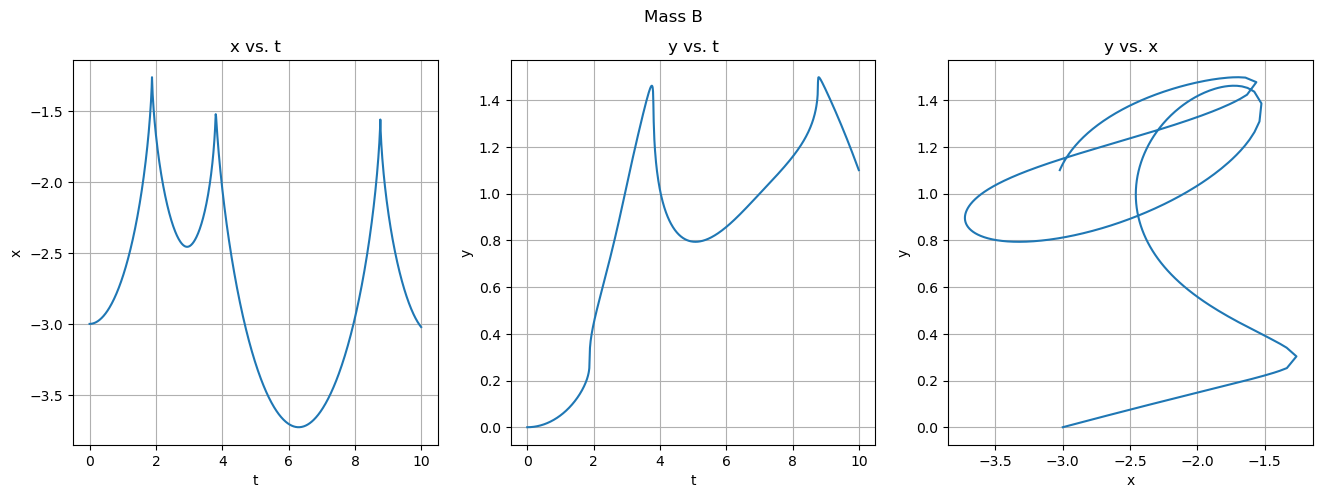

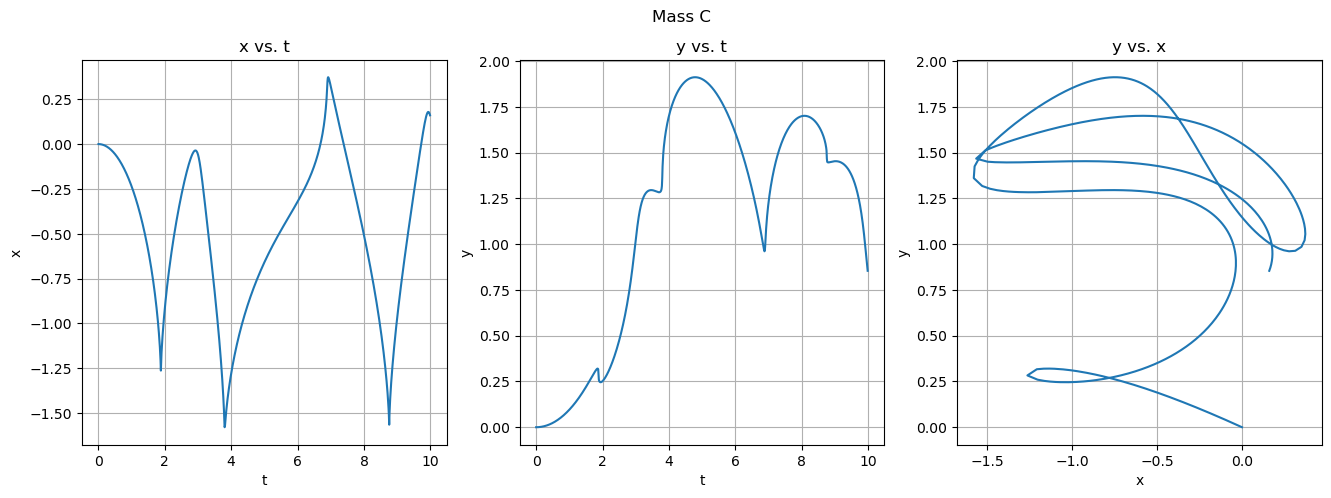

In [55]:
import numpy as np
import scipy as sp
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def forcei(r,m,i):
    G = 1
    sum = [0,0]
    sign = np.zeros(2)
    if type(r[i]) != (list or numpy.array):       #orgonizes list into x,y positions
        r = [[r[0],r[1]],[r[2],r[3]],[r[4],r[5]]]
    for j in range(len(r)):
        if i !=j:
            dist = np.subtract(r[i],r[j])         #finds dist between two points
            dist = dist**2                        #sqrs the dists
            divfactor = (np.sqrt(np.sum(dist)))**3      #finds factor to divide by
            sum += -G*m[j]*np.subtract(r[i],r[j])/divfactor    # calcs ax and ay
    return sum

def positions(states,t):
    val = np.zeros(12)
    val[0], val[1] = states[6], states[7]            #records initial position of particle 1 to state 6 and 7
    val[2], val[3] = states[8], states[9]            #records initial position of particle 2 to state 8 and 9
    val[4], val[5] = states[10], states[11]          #records initial position of particle 3 to state 10 and 11
    val[6], val[7] = forcei(states[0:6],mass,0)      #calcs force given pos and mass
    val[8], val[9] = forcei(states[0:6],mass,1)      #calcs force given pos and mass
    val[10], val[11] = forcei(states[0:6],mass,2)    #calcs force given pos and mass
    return val
    
    

#initial values
pos = [[0,4],[-3,0],[0,0]]
vels = [[0,0],[0,0],[0,0]]
cond = [0,4,-3,0,0,0,0,0,0,0,0,0]
mass = [3,4,5]
print(forcei(pos,mass,0))

dt =.01
t = np.arange(0,10,dt)

mass_positions = integrate.odeint(positions, cond, t) #uses odeint to get the postitions throughout time

%matplotlib inline
index_list = [0, 2, 4]
mass_name_list = ['A', 'B', 'C']
i=0
for index in index_list:
    mass_name = mass_name_list[i]
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 5))
    ax1.plot(t, mass_positions[:, index])
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.set_title('x vs. t')
    ax1.grid()
    
    ax2.plot(t, mass_positions[:, index+1])
    ax2.set_xlabel('t')
    ax2.set_ylabel('y')
    ax2.set_title('y vs. t')
    ax2.grid()
    
    ax3.plot(mass_positions[:, index], mass_positions[:, index+1])
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_title('y vs. x')
    ax3.grid()
    
    fig.suptitle(f'Mass {mass_name}')
    i+=1
    plt.show()

<IPython.core.display.Javascript object>


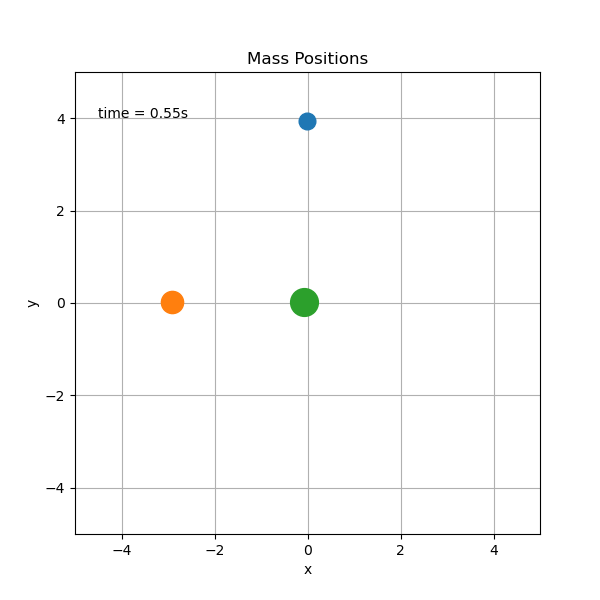

In [96]:
# Animation code
%matplotlib notebook
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-5, 5), ylim=(-5, 5))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mass Positions')
ax.grid()

ma_marker, = ax.plot([], [], 'o-', markersize=12)
mb_marker, = ax.plot([], [], 'o-', markersize=16)
mc_marker, = ax.plot([], [], 'o-', markersize=20)
time_template = 'time = %.2fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    ma_marker.set_data([], [])
    mb_marker.set_data([], [])
    mc_marker.set_data([], [])
    time_text.set_text('')
    return ma_marker, mb_marker, mc_marker, time_text

def animate(i):
    ma_marker.set_data(mass_positions[i, 0], mass_positions[i, 1])
    mb_marker.set_data(mass_positions[i, 2], mass_positions[i, 3])
    mc_marker.set_data(mass_positions[i, 4], mass_positions[i, 5])
    time_text.set_text(time_template % (i*dt))
    return ma_marker, mb_marker, mc_marker, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(t)), interval=10, blit=True, init_func=init)
plt.show()

(b) A new, stable solution for the equal-mass 3-body problem was discovered in 2000 by Prof. R. Montgomery (UCSC) and A. Chenciner (Annals of Mathematics 152: 881-901). Find the motion of the 3-body system with all 3 masses set to $m = 1$, $G = 1$, and initial conditions given in Figure 1 of the paper. This system is called the “figure-eight” orbit. 

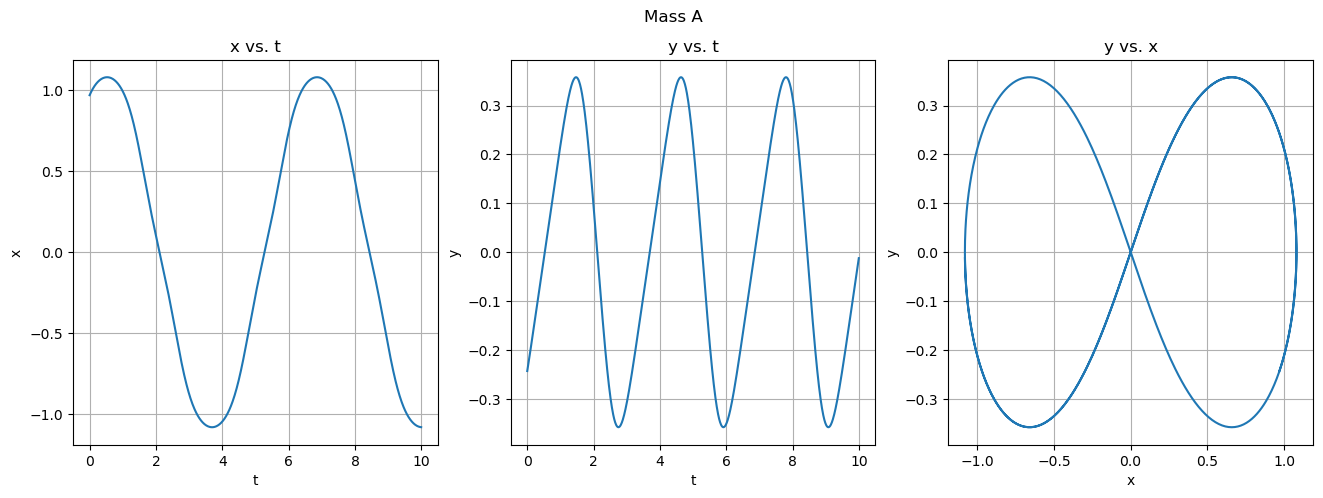

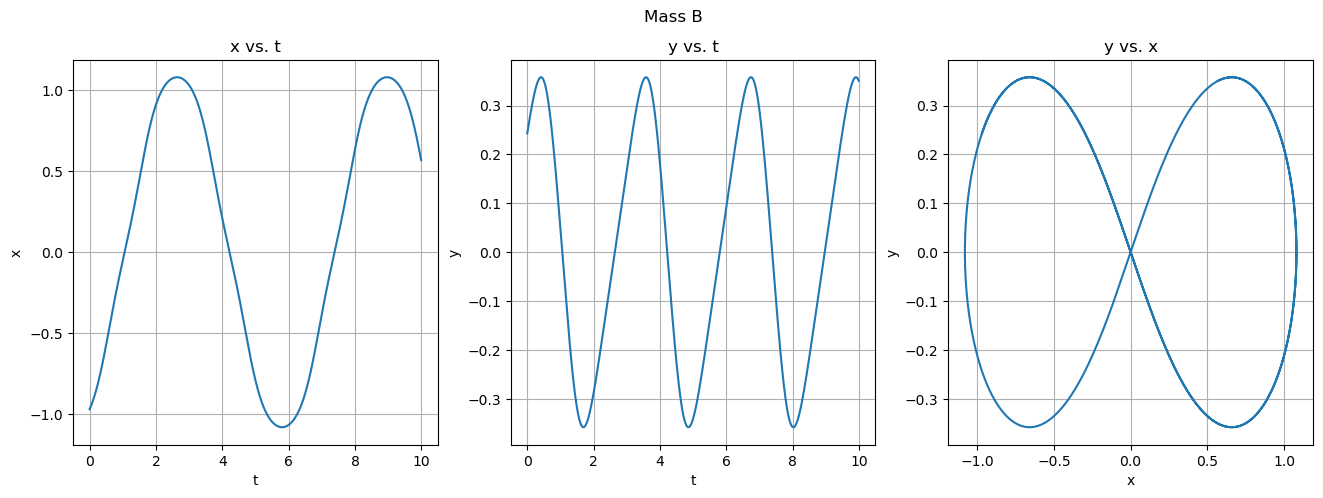

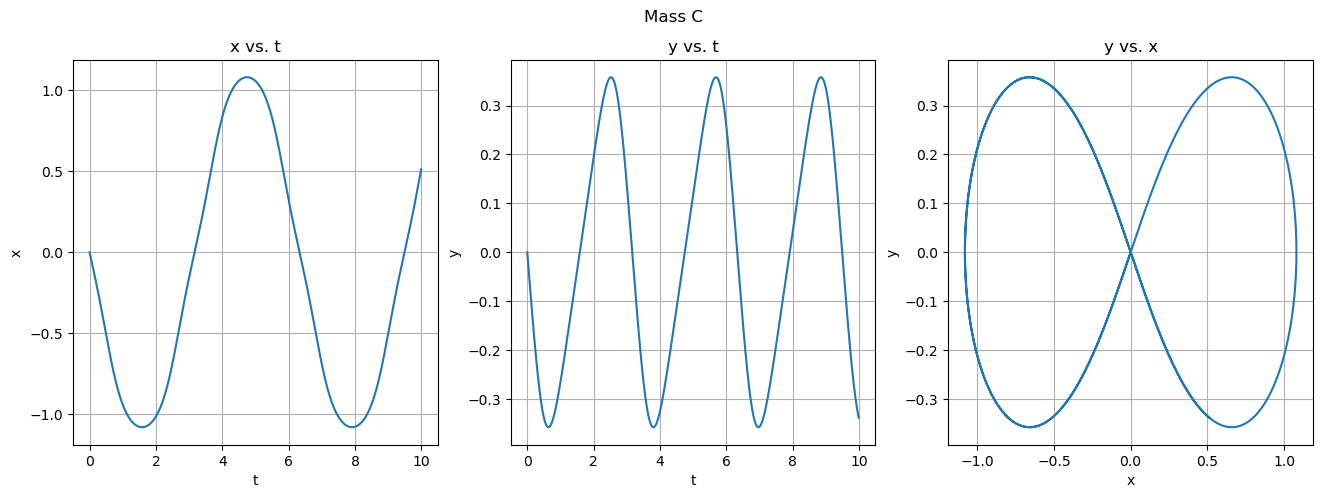

In [56]:
mass = [1,1,1]
x_pos = 0.97000436
y_pos = -0.24308753
x_v = -0.93240737
y_v = -0.86473146
cond = [x_pos, y_pos, -x_pos, -y_pos, 0,0, -1/2*x_v, -1/2*y_v, -1/2*x_v, -1/2*y_v, x_v, y_v]
mass_positions = integrate.odeint(positions, cond, t)



%matplotlib inline
index_list = [0, 2, 4]
mass_name_list = ['A', 'B', 'C']
i=0
for index in index_list:
    mass_name = mass_name_list[i]
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 5))
    ax1.plot(t, mass_positions[:, index])
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.set_title('x vs. t')
    ax1.grid()
    
    ax2.plot(t, mass_positions[:, index+1])
    ax2.set_xlabel('t')
    ax2.set_ylabel('y')
    ax2.set_title('y vs. t')
    ax2.grid()
    
    ax3.plot(mass_positions[:, index], mass_positions[:, index+1])
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_title('y vs. x')
    ax3.grid()
    
    fig.suptitle(f'Mass {mass_name}')
    i+=1
    plt.show()

<IPython.core.display.Javascript object>


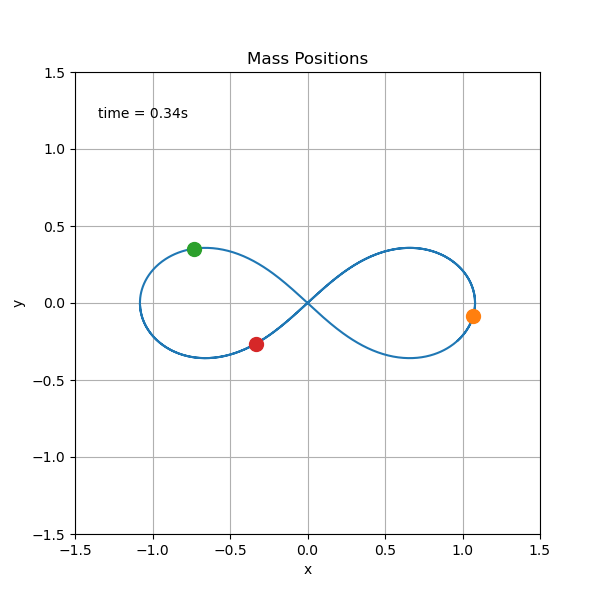

In [98]:
# Animation code
%matplotlib notebook
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mass Positions')
ax.plot(mass_positions[:, 0], mass_positions[:, 1])
ax.grid()

ma_marker, = ax.plot([], [], 'o-', markersize=10)
mb_marker, = ax.plot([], [], 'o-', markersize=10)
mc_marker, = ax.plot([], [], 'o-', markersize=10)
time_template = 'time = %.2fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    ma_marker.set_data([], [])
    mb_marker.set_data([], [])
    mc_marker.set_data([], [])
    time_text.set_text('')
    return ma_marker, mb_marker, mc_marker, time_text

def animate(i):
    ma_marker.set_data(mass_positions[i, 0], mass_positions[i, 1])
    mb_marker.set_data(mass_positions[i, 2], mass_positions[i, 3])
    mc_marker.set_data(mass_positions[i, 4], mass_positions[i, 5])
    time_text.set_text(time_template % (i*dt))
    return ma_marker, mb_marker, mc_marker, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(t)), interval=10, blit=True, init_func=init)
plt.show()

(c) Check the stability of the “figure-eight” orbit by changing the initial conditions slightly and checking the orbit again.  Consider the following changes:

* Increase all parameters by 1%
* Increase all parameters by 2%
* Increase parameters for particles $A$ and $B$ by 3%, and increase the run time to 500.  

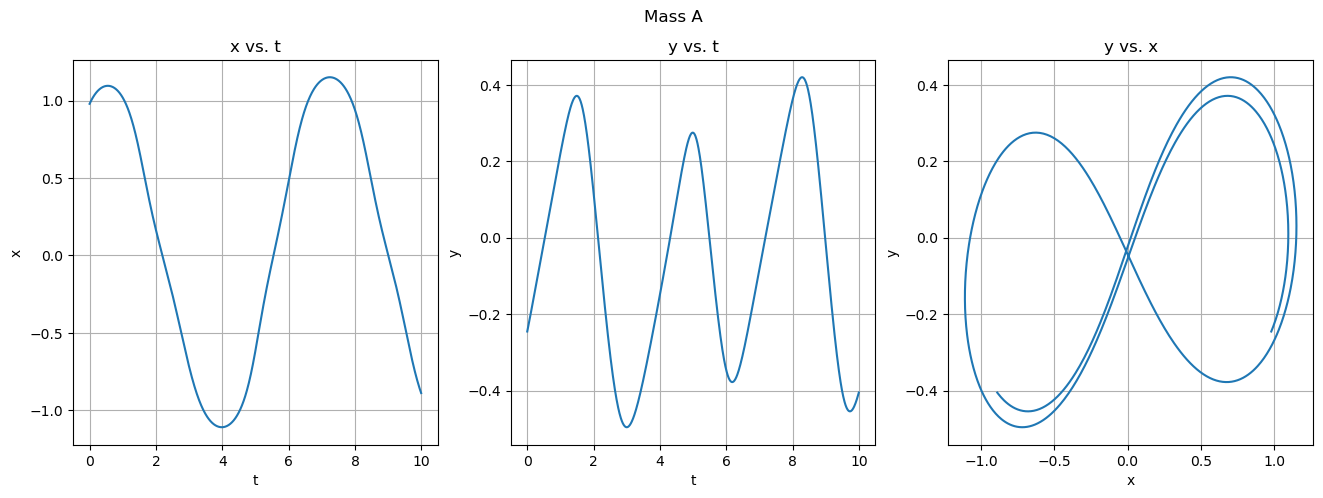

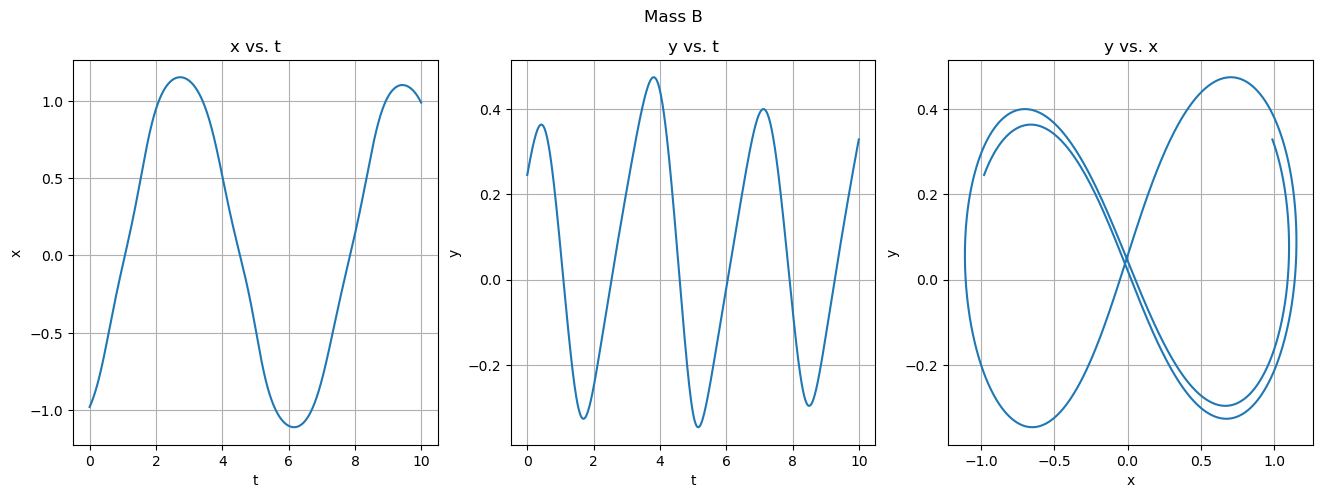

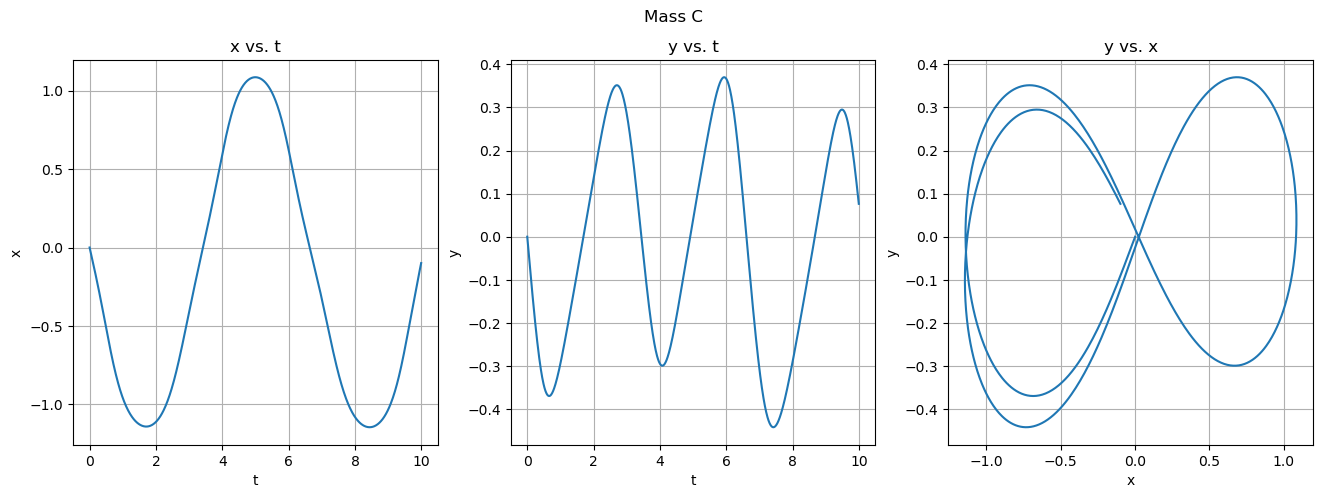

In [57]:
mass = [1,1,1]
x_pos = 0.97000436*1.01
y_pos = -0.24308753*1.01
x_v = -0.93240737*1.01
y_v = -0.86473146*1.01
cond = [x_pos, y_pos, -x_pos, -y_pos, 0,0, -1/2*x_v, -1/2*y_v, -1/2*x_v, -1/2*y_v, x_v, y_v]
mass_positions = integrate.odeint(positions, cond, t)



%matplotlib inline
index_list = [0, 2, 4]
mass_name_list = ['A', 'B', 'C']
i=0
for index in index_list:
    mass_name = mass_name_list[i]
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 5))
    ax1.plot(t, mass_positions[:, index])
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.set_title('x vs. t')
    ax1.grid()
    
    ax2.plot(t, mass_positions[:, index+1])
    ax2.set_xlabel('t')
    ax2.set_ylabel('y')
    ax2.set_title('y vs. t')
    ax2.grid()
    
    ax3.plot(mass_positions[:, index], mass_positions[:, index+1])
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_title('y vs. x')
    ax3.grid()
    
    fig.suptitle(f'Mass {mass_name}')
    i+=1
    plt.show()

While less stable, this should be stable throughout time.

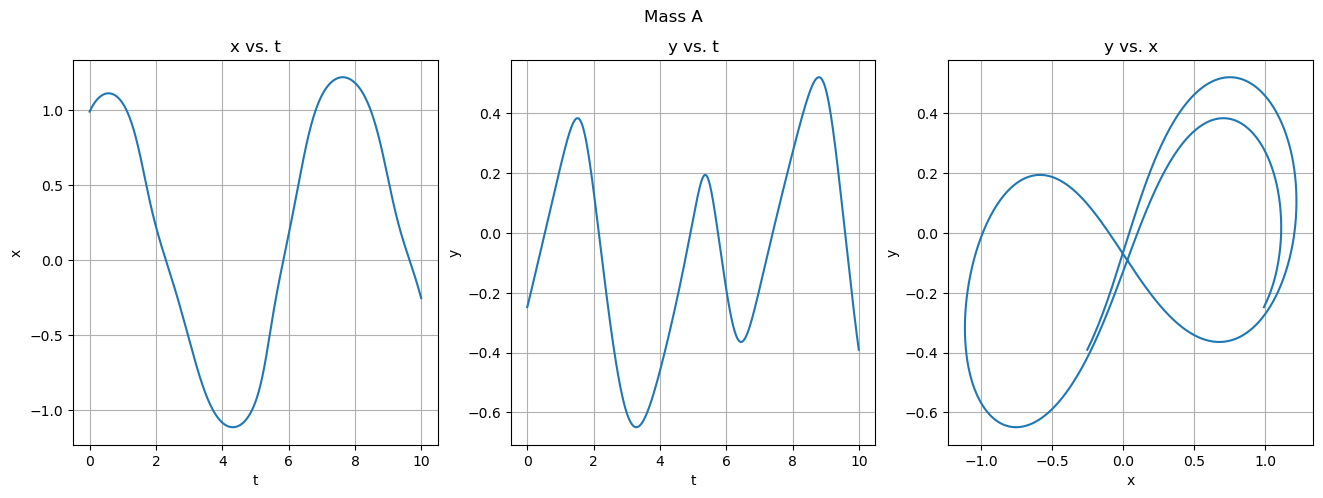

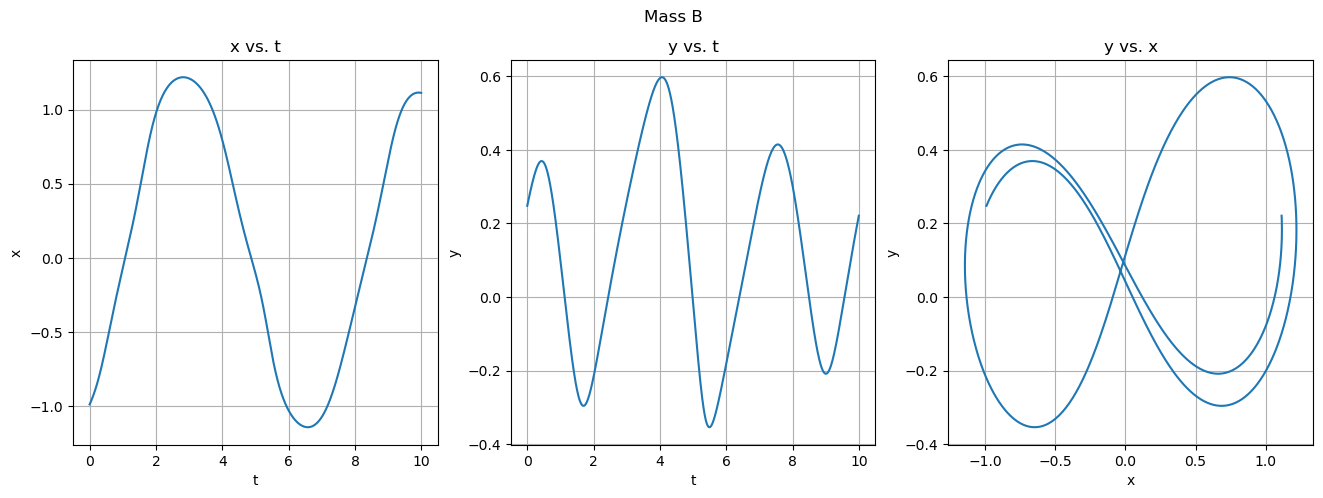

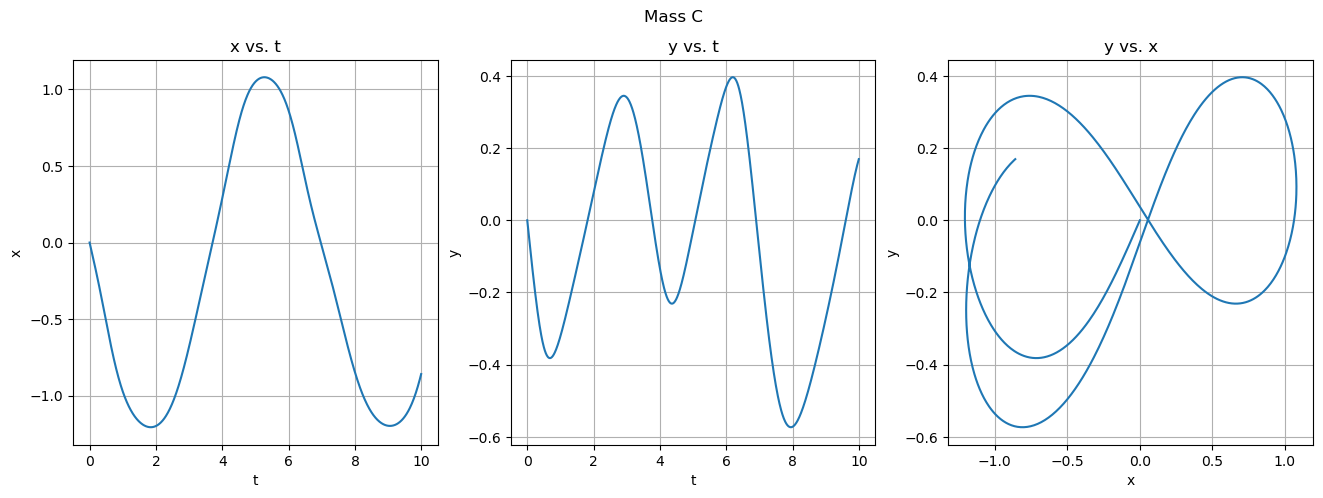

In [100]:
mass = [1,1,1]
x_pos = 0.97000436*1.02
y_pos = -0.24308753*1.02
x_v = -0.93240737*1.02
y_v = -0.86473146*1.02
cond = [x_pos, y_pos, -x_pos, -y_pos, 0,0, -1/2*x_v, -1/2*y_v, -1/2*x_v, -1/2*y_v, x_v, y_v]
mass_positions = integrate.odeint(positions, cond, t)



%matplotlib inline
index_list = [0, 2, 4]
mass_name_list = ['A', 'B', 'C']
for i in range(3):
    first_index = index_list[i]
    mass_name = mass_name_list[i]
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 5))
    ax1.plot(t, mass_positions[:, first_index])
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.set_title('x vs. t')
    ax1.grid()
    
    ax2.plot(t, mass_positions[:, first_index+1])
    ax2.set_xlabel('t')
    ax2.set_ylabel('y')
    ax2.set_title('y vs. t')
    ax2.grid()
    
    ax3.plot(mass_positions[:, first_index], mass_positions[:, first_index+1])
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_title('y vs. x')
    ax3.grid()
    
    fig.suptitle(f'Mass {mass_name}')
    plt.show()

These positions seem to fluctuate even more but still look stable.

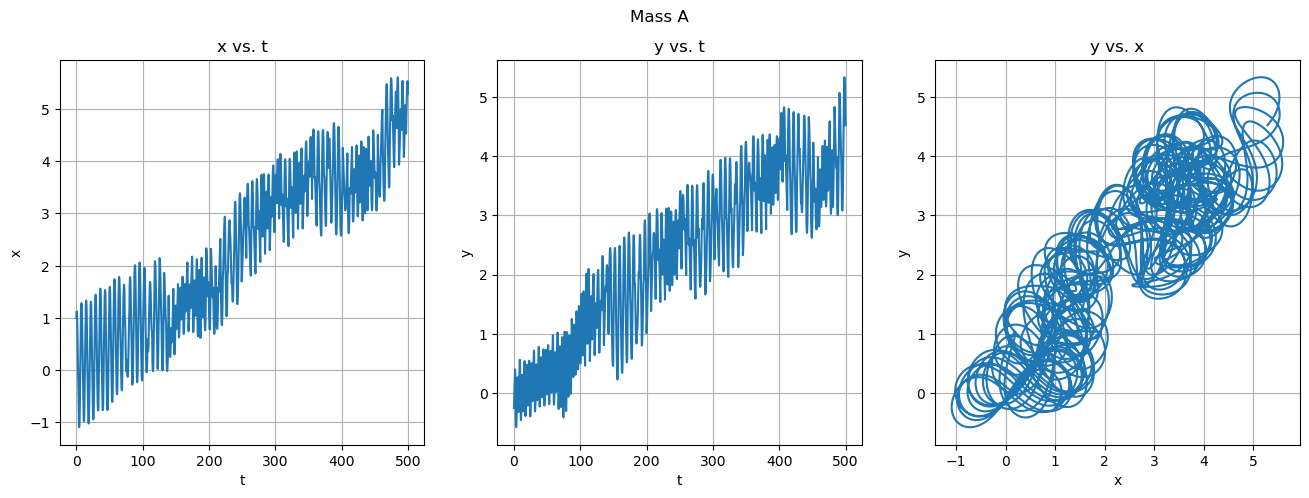

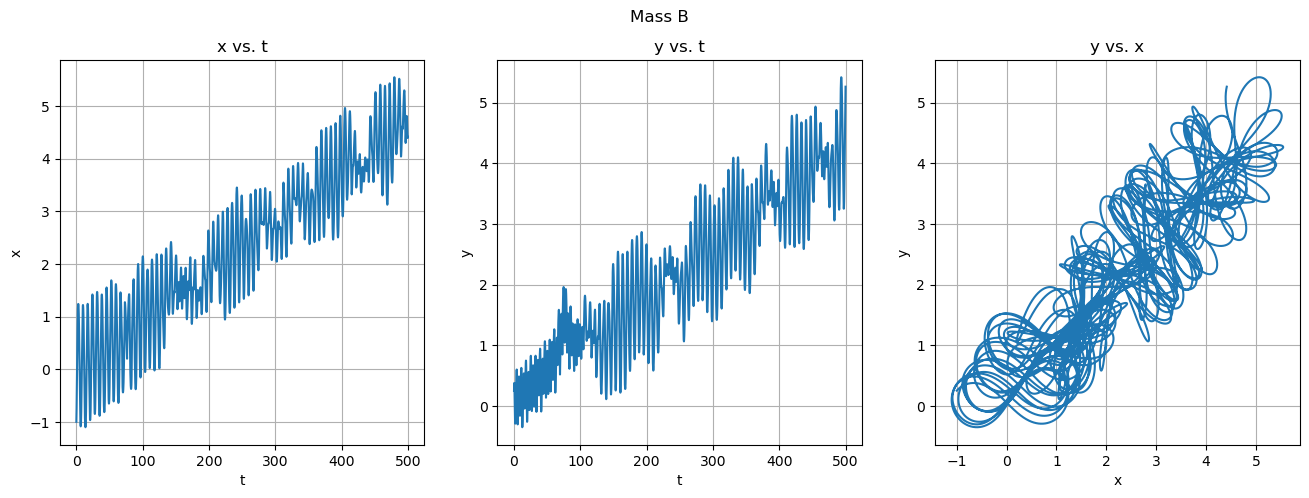

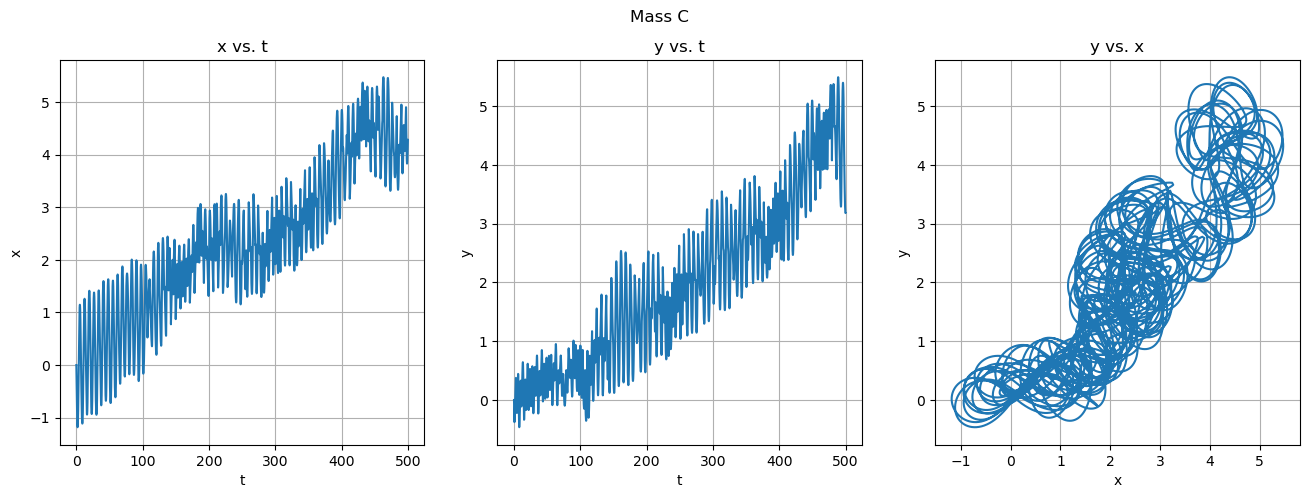

In [58]:
mass = [1,1,1]   #maybe increase mass too
x_pos = 0.97000436*1.03
y_pos = -0.24308753*1.03
x_v = -0.93240737*1.03
y_v = -0.86473146*1.03
x_vC = -0.93240737
y_vC = -0.86473146

cond = [x_pos, y_pos, -x_pos, -y_pos, 0,0, -1/2*x_v, -1/2*y_v, -1/2*x_v, -1/2*y_v, x_vC, y_vC]
t = np.arange(0,500,dt)
mass_positions = integrate.odeint(positions, cond, t)



%matplotlib inline
index_list = [0, 2, 4]
mass_name_list = ['A', 'B', 'C']
for i in range(3):
    first_index = index_list[i]
    mass_name = mass_name_list[i]
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 5))
    ax1.plot(t, mass_positions[:, first_index])
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.set_title('x vs. t')
    ax1.grid()
    
    ax2.plot(t, mass_positions[:, first_index+1])
    ax2.set_xlabel('t')
    ax2.set_ylabel('y')
    ax2.set_title('y vs. t')
    ax2.grid()
    
    ax3.plot(mass_positions[:, first_index], mass_positions[:, first_index+1])
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_title('y vs. x')
    ax3.grid()
    
    fig.suptitle(f'Mass {mass_name}')
    plt.show()

Interestingly, while this plot is unstable, the positions do stay together throughout time. They keep orbiting each other as t increases even while moving from the inital starting position.

## Problem 3: Vibrating Strings

Even though the equation of a vibrating string (with length $L$, linear mass density $\mu( x )$, and tension $T$) is a partial differential equation:

$$\frac{\partial^2 u(x,y)}{\partial t^2} = \frac{T}{\mu(x)}\frac{\partial^2 u(x,t)}{\partial x^2}$$

the use of a solution $u( x, t) = y( x )\tau(t)$ allows us to separate the equation into a spatial side and a temporal side:

$$\frac{1}{\tau(t)}\frac{d^2 \tau(t)}{dt^2} = \frac{1}{y(x)}\frac{T}{\mu(x)}\frac{d^2 y(x)}{dx^2}$$

where the separation constant is taken to be $-\omega^2$.

(a) Show (analytically) that if $\mu(x)=\mu_0=\mathrm{constant}$ then the spatial solution for $y(x)$ is:

$$y(x)=\alpha\sin\left(\omega x\sqrt{\frac{\mu_0}{T}}\right) + \beta\cos\left(\omega x\sqrt{\frac{\mu_0}{T}}\right)$$

If the seperation constant = $-\omega^2$ then:
$$ -\omega^2\frac{\mu_0}{T} y = \frac{d^2y}{dx^2} $$
solving the partial differential equation gives:
$$ y(x) = \alpha \sin{(\omega x \sqrt{\frac{\mu_0}{T}})}+ \beta \cos(\omega x \sqrt{\frac{\mu_0}{T}}) $$

(b) Now set the boundary condition $y(x)=0$ at both ends of the string, and show that the allowed values of $\omega$ are:

$$\omega = \frac{n\pi}{L}\sqrt{\frac{T}{\mu_0}}$$

$$ y(0) = 0 = \beta \cos(0)$$
therefore $\beta = 0$
$$ y(L) = 0 = \alpha \sin(L \omega \sqrt{\frac{\mu_0}{T}}) $$
$$ \sin^{-1}(0) = L \omega \sqrt{\frac{\mu_0}{T}} $$
$$ n \pi = L \omega \sqrt{\frac{\mu_0}{T}} $$
$$ \omega = \frac{n \pi}{L}  \sqrt{\frac{T}{\mu_0}} $$

(c) Now use the shooting method with boundary conditions to find the lowest frequency of the string and plot the shape of the eigenfunction.  Use $L=1$ m, $m=0.954$ kg, and $T=1000$ N.  Assume a constant value of $\mu_0$ for this part.

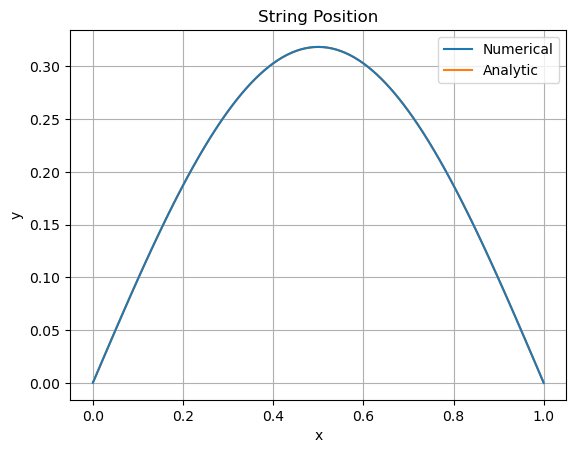

w = 101.71281847667764
Analytic w = 101.71281765724028


In [77]:
L = 1
m = .954
T = 1000
n=1
# w = n * np.pi / L * np.sqrt(T/mu)

def vib_string(state, t, w):
    out = np.zeros(2)                 #set return state 
    mu = m/L                          #set a value for mu
    out[0] = state[1]                 
    out[1] = -(mu/T)*(w**2)*state[0] 
    return out

#controls
beta = 0
h=.01
x = np.arange(0,1.000001,h)
initial = [0,1]
eps = 1e-8

w = np.zeros(3)
w[0], w[1] = 1, 150          #set initial guesses for w, w0 is min w1 is max
z = np.zeros(3)
y = integrate.odeint(vib_string, initial, x, args=(w[0],))     #solve differential eq with w0
z[0] = y[-1,0]               #set data test val to last value of y
z[1] = integrate.odeint(vib_string, initial, x, args=(w[1],))[-1,0]  #solve dif eq with w1

w[2] = w[1] + (beta - z[1])*(w[1]-w[0])/(z[1]-z[0])            #solve for better w guess



while True:
    y = integrate.odeint(vib_string, initial, x, args=(w[2],)) 
    z[2] = y[-1,0]
    
    if abs(z[2]) < eps:                                        #check if solution is within precision 
        break
    w[0] = w[1]                                                #cycle values
    z[0] = z[1]
    w[1] = w[2]
    z[1] = z[2]
    w[2] = w[1] + (beta - z[1])*(w[1]-w[0])/(z[1]-z[0])

plt.plot(x, y[:, 0], label = 'Numerical')
analytic_w = ((np.pi)/L)*np.sqrt(T/(m/L))
alpha = 1/(analytic_w*np.sqrt((m/L)/T))
analytic_y = alpha*np.sin(analytic_w*np.sqrt((m/L)/T)*x)
plt.plot(x, analytic_y, label='Analytic', zorder=0)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.title('String Position')
plt.show()
print (f'w = {w[2]}')
print(f'Analytic w = {analytic_w}')
q3pc = analytic_y

(d) Repeat the shooting method with $\mu(x)=(0.954 \mathrm{g/m} + (x-\frac{L}{2})0.8 \mathrm{g/m^2})$.  Plot the shape of the eigenfunction and compare the shape and frequency with the results from part (c).

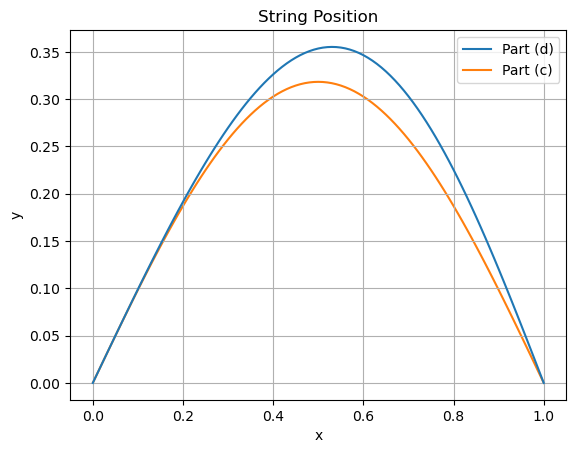

w = 3204.370968392136


In [103]:
def string_vibes(state,t,w):
    #same process with mu set
    out = np.zeros(2)
    mu = m*.001/L + (t - L/2)*.0008
    out[0] = state[1]
    out[1] = -(mu/T)*(w**2)*state[0]
    return out

w[0], w[1] = 1, 4000
z = np.zeros(3)
y = integrate.odeint(string_vibes, initial, x, args=(w[0],))
z[0] = y[-1,0]
z[1] = integrate.odeint(string_vibes, initial, x, args=(w[1],))[-1,0]
w[2] = w[1] + (beta - z[1])*(w[1]-w[0])/(z[1]-z[0])

while True:
    y = integrate.odeint(string_vibes, initial, x, args=(w[2],))
    z[2] = y[-1,0]
    if abs(z[2]) < eps:
        break
    w[0] = w[1]
    z[0] = z[1]
    w[1] = w[2]
    z[1] = z[2]
    w[2] = w[1] + (beta - z[1])*(w[1]-w[0])/(z[1]-z[0])

plt.plot(x, y[:, 0], label='Part (d)')
plt.plot(x, q3pc, label='Part (c)', zorder=0)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.title('String Position')
plt.show()
print (f'w = {w[2]}')

The shape is nearly the same but the new solution is shifted up at the peak and now not symetric. The $\omega$ value for the constant c value was rather small while the x dependent $\omega$ was much larger. If part c is tested with an initail guess for $\omega$ between 3000 and 3300, a value of 3150 can be produced showing that there is also a state near that point for both solutions.

## Problem 4: More on Laplace's Equation

This problem is the follow-up to the electrostatic potential case we analyzed in class. The top edge of the square plate is kept at 100 V potential, and the other 3 edges are kept at 0 V:

<img src="../Lectures/Figures/Figure_19.1a.png" width="20%">

(a) Calculate the electrostatic potential everywhere on the square plate, as we did in class, but using 1000 iterations. Draw the $V$ axis as equipotential contours instead of a 3-D surface plot.

In [38]:
def lap(dim,Niter,h):
    Nmax = int(dim/h)                               #calcs Nmax using the dimensions of the box and step size
    V = np.zeros((Nmax+1,Nmax+1))
    for k in range(0, Nmax+1): 
        V[k,0] = 100.0                              # fixed potential line at 100V

    for iter in range(Niter):                       # iterations over algorithm
        for i in range(1, Nmax):                                                
            for j in range(1,Nmax): 
                V[i,j] = 0.25*(V[i+1,j]+V[i-1,j]+V[i,j+1]+V[i,j-1]) 

    x = np.arange(0,dim+h,h)
    y = np.arange(0,dim+h,h)
    x_index = np.array([i for i in range(len(x))])
    y_index = np.array([i for i in range(len(y))])
    X, Y = np.meshgrid(x,y)
    X_index, Y_index = np.meshgrid(x_index, y_index)
    Z = V[X_index, Y_index]
    
    return X,Y,Z

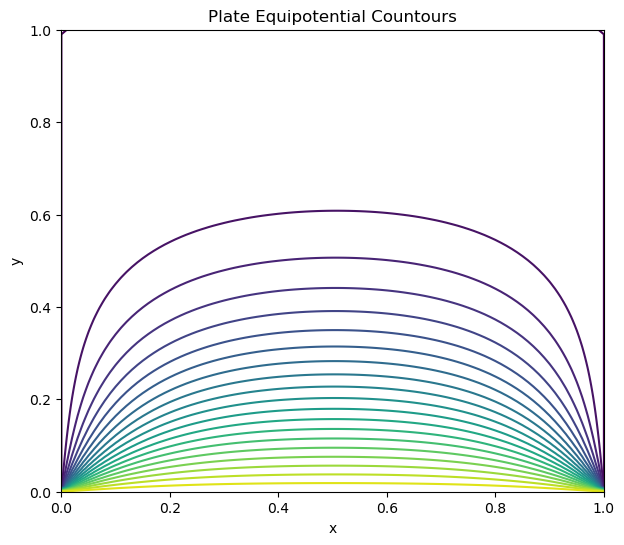

In [39]:
dim = 1
iterations = 1000
h=.01
X,Y,Z = lap(dim,iterations,h)
fig, ax = plt.subplots(figsize=(7,6))
qcs = ax.contour(X,Y,Z, levels=np.arange(0,105,5))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title("Plate Equipotential Countours")
plt.show()

(b) Repeat the process for different step sizes $h={0.01, 0.02, 0.05, 0.1, 0.2, 0.5}$ and draw conclusions about the stability and accuracy of the solution. 

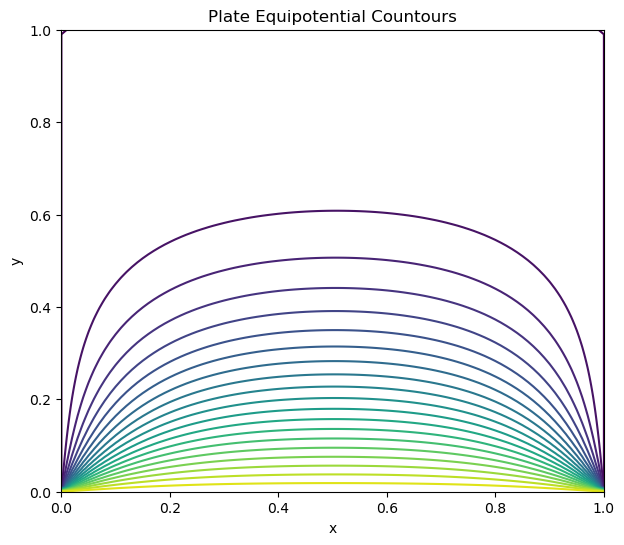

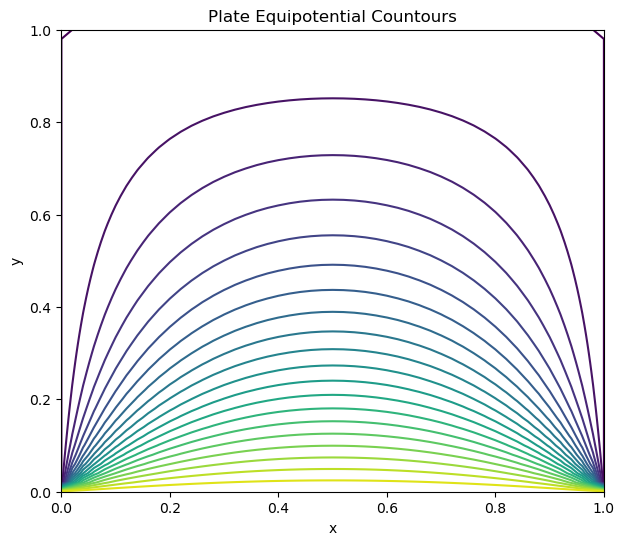

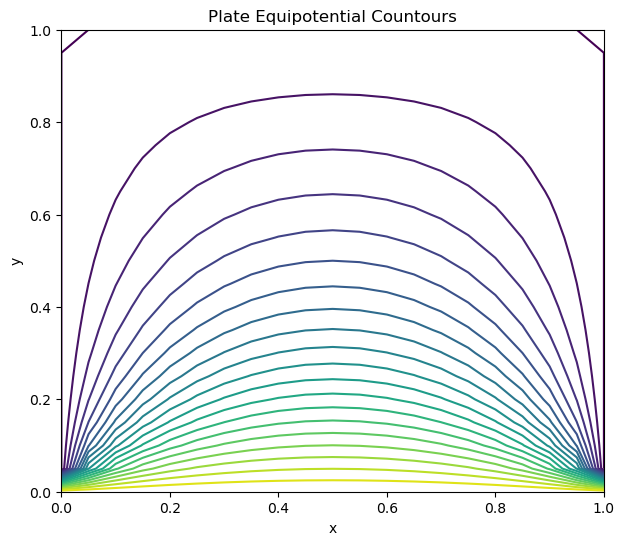

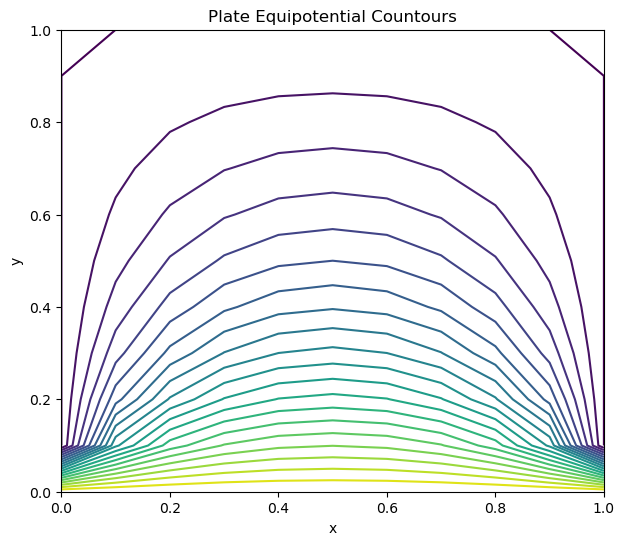

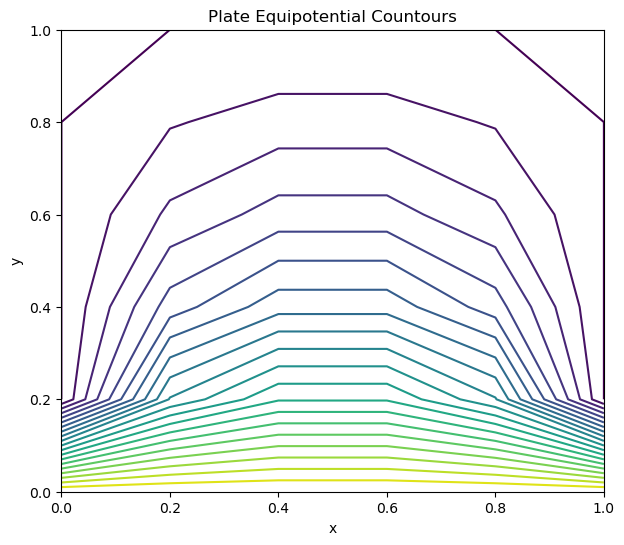

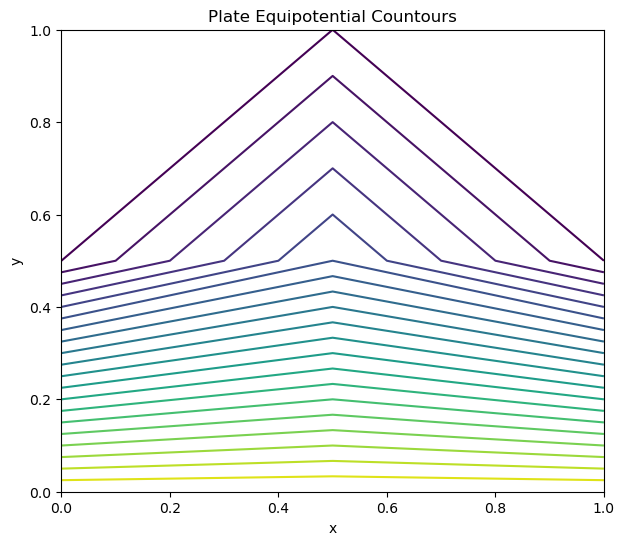

In [40]:
h_list = [.01,.02,.05,.1,.2,.5]
for h in h_list:
    X,Y,Z = lap(1,iterations,h)
    fig, ax = plt.subplots(figsize=(7,6))
    qcs = ax.contour(X,Y,Z, levels=np.arange(0,105,5))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title("Plate Equipotential Countours")
    plt.show()

(c) Modify the program so that the iterations stop once the solution has converged. How does the number of iterations required change with the tolerance? 

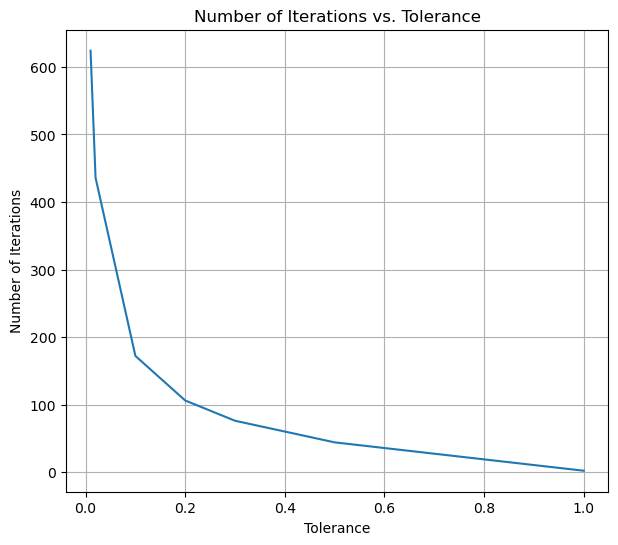

In [41]:
def lap_con(dim,h,eps):
    Nmax = int(dim/h)
    V = np.zeros((Nmax+1,Nmax+1))
    
    for k in range(0, Nmax+1): 
        V[k,0] = 100.0                              # fixed potential line at 100V
    
    storage = np.copy(V)
    niter = 1
    
    while True:                                     # iterations over algorithm
        check = 0
        for i in range(1, Nmax):                                                
            for j in range(1,Nmax): 
                V[i, j] = 0.25 * (V[i + 1, j] + V[i - 1, j] + V[i, j + 1] + V[i, j - 1])

        points = 0
        for i in range(1,Nmax):                     # checks for convergence at each point allowed to change
            for j in range(1,Nmax):
                if np.abs((V[i,j] - storage[i,j])/V[i,j]) < eps:
                    check +=1
                points +=1
                    
        if check == points:                         # stops iteration if all points converge
            break

        storage = np.copy(V)
        niter +=1

    x = np.arange(0,dim+h,h)
    y = np.arange(0,dim+h,h)
    x_index = np.array([i for i in range(len(x))])
    y_index = np.array([i for i in range(len(y))])
    X, Y = np.meshgrid(x,y)
    X_index, Y_index = np.meshgrid(x_index, y_index)
    Z = V[X_index, Y_index]
    
    return X,Y,Z, niter

dimension = 1
h = .01
tolerance_list = [1, 5e-1, 3e-1, 2e-1, 1e-1, 2e-2, 1e-2]
iteration_list = []
for tolerance in tolerance_list:
    X, Y, Z, n_iter = lap_con(dimension, h, tolerance)
    iteration_list.append(n_iter)

fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(tolerance_list, iteration_list)
ax.set_xlabel('Tolerance')
ax.set_ylabel('Number of Iterations')
ax.set_title('Number of Iterations vs. Tolerance')
ax.grid()
plt.show()

(d) Implement the successive over-relaxation technique to accelerate the convergence. What value of relaxation parameter (called $\alpha$ in lecture, $\omega$ in the textbook) gives the fastest convergence?  Double-check that the result looks reasonable for that optimal value.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
# same math as part c with addition of a relaxation step

def lap_rel(dim, h, eps, alpha, nmax):
    # if alpha == 1:
    #     alpha += -.01
    n_points = int(dim / h)
    V = np.zeros((n_points + 1, n_points + 1))

    for k in range(0, n_points + 1):
        V[k, 0] = 100.0

    storage = np.copy(V)
    n_iter = 1
    while True:
        check = 0
        for i in range(1, n_points):
            for j in range(1, n_points):
                V[i, j] = 0.25 * (V[i + 1, j] + V[i - 1, j] + V[i, j + 1] + V[i, j - 1])
                V[i, j] = V[i, j] + alpha * (V[i, j] - storage[i, j])  # Relaxation

        points = 0
        for i in range(1, n_points):
            for j in range(1, n_points):
                points +=1
                if np.abs((V[i, j] - storage[i, j])/V[i,j]) < eps:
                    check += 1

        if check == points:
            print(f"for alpha = {np.round(alpha,3)}, number of iterations = {n_iter}")
            break

        # print(n_iter, check, alpha)
        if n_iter > nmax:
            n_iter = False
            print(f"for alpha = {np.round(alpha,3)}, number of iterations is greater than smaller alpha")
            break
        n_iter += 1
        storage = np.copy(V)

    x = np.arange(0,dim+h,h)
    y = np.arange(0,dim+h,h)
    x_index = np.array([i for i in range(len(x))])
    y_index = np.array([i for i in range(len(y))])
    X, Y = np.meshgrid(x,y)
    X_index, Y_index = np.meshgrid(x_index, y_index)
    Z = V[X_index, Y_index]
    return X, Y, Z, n_iter


dim = 1
h = .01
eps = 1e-2
alpha_list = np.arange(0, 1.01, 0.1)
iteration_list = []
nmax = 10000
for alpha in alpha_list:
    X, Y, Z, n_iter = lap_rel(dim, h, eps, alpha,nmax)
    nmax = n_iter
    iteration_list.append(n_iter)


for i in range(len(iteration_list)):    #finds the index of the best alpha value
    if iteration_list[i] == False:
        best_index = i-1

alpha_listv2 = np.arange(alpha_list[best_index-1], alpha_list[best_index + 1], 0.01)

nmax = 1000
iteration_listv2 = [1000, 1000]
for alpha in alpha_listv2:              #does a higher precision search near the best alpha
    X, Y, Z, n_iter = lap_rel(dim, h, eps, alpha, nmax)
    iteration_listv2.append(n_iter)
    if iteration_listv2[-1] == False:
        best_alpha = alpha - .01
        break
    nmax = n_iter


print(f"Best alpha for L={dim}, h={h} =", np.round(best_alpha, 3))



for alpha = 0.0, number of iterations = 624
for alpha = 0.1, number of iterations = 558
for alpha = 0.2, number of iterations = 497
for alpha = 0.3, number of iterations = 441
for alpha = 0.4, number of iterations = 386
for alpha = 0.5, number of iterations = 334
for alpha = 0.6, number of iterations = 281
for alpha = 0.7, number of iterations = 227
for alpha = 0.8, number of iterations = 169
for alpha = 0.9, number of iterations = 117
for alpha = 1.0, number of iterations is greater than smaller alpha
for alpha = 0.8, number of iterations = 169
for alpha = 0.81, number of iterations = 163
for alpha = 0.82, number of iterations = 156
for alpha = 0.83, number of iterations = 150
for alpha = 0.84, number of iterations = 143
for alpha = 0.85, number of iterations = 137
for alpha = 0.86, number of iterations = 130
for alpha = 0.87, number of iterations = 123
for alpha = 0.88, number of iterations = 117
for alpha = 0.89, number of iterations = 115
for alpha = 0.9, number of iterations is gr

for alpha = 0.89, number of iterations = 589


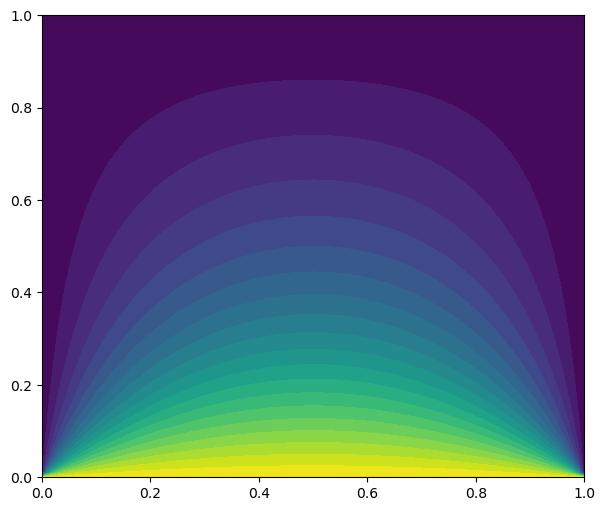

In [51]:
num_X, num_Y, num_Z, num_iter = lap_rel(dimension, h, eps, .89,1000)
fig, ax = plt.subplots(figsize=(7,6))
num = ax.contourf(num_X, num_Y, num_Z, levels=np.arange(0, 105, 5))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Plate Equipotential Contours (best_alpha)')
ax1.set_aspect('equal', adjustable='box')

(e) Compare your numerical result with the analytic result given in Eqn. 19.18:

$$
V(x,y)=\sum_{n=1,3,5,...}^{\infty}\frac{400}{n\pi}\sin\left(\frac{n\pi x}{L}\right)\frac{\sinh(n\pi y/L)}{\sinh(n\pi)}
$$

Hint #1: do not be surprised if you need to sum lots (hundreds!  thousands?) of terms before the analytic solution converges!

Hint #2: Use the following formula for large $N$ (Eqn. 19.19 in our textbook):

$$\frac{\sinh(n\pi x/L)}{\sinh(n\pi)} = \frac{e^{n\pi(x/L-1)} - e^{-n\pi(x/L+1)}}{1-e^{-2n\pi}} \longrightarrow e^{n\pi (x/L-1)}$$

53


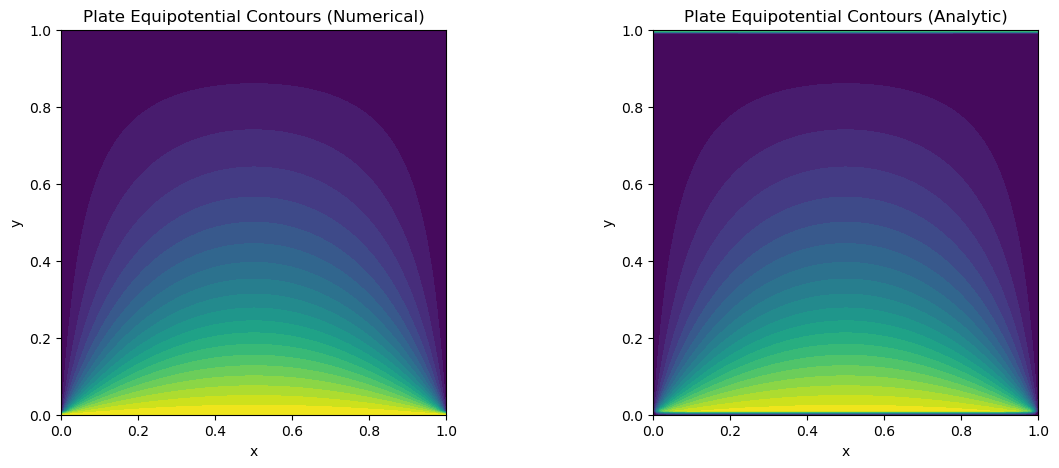

In [83]:
import numpy as np
import matplotlib.pyplot as plt

def anal(x, y, L,i):
    if i>150:
        tot = 400 / (i * np.pi) * np.sin((i * np.pi * x) / L) * np.exp(i * np.pi * (x / L - 1))
    else:
        tot = 400 / (i * np.pi) * np.sin((i * np.pi * x) / L) * (np.sinh((i*np.pi*y)/L)/np.sinh(i*np.pi))
    return tot


def lap_anal(dim, h, eps):
    Nmax = int(dim / h)
    V = np.zeros((Nmax + 1, Nmax + 1))
    x = np.arange(0,dim+h,h)
    y = np.arange(0,dim+h,h)
    x_index = np.array([i for i in range(len(x))])
    y_index = np.array([i for i in range(len(y))])
    X, Y = np.meshgrid(x,y)
    X_index, Y_index = np.meshgrid(x_index, y_index)


    for k in range(0, Nmax + 1):
        V[k, 0] = 100.0

    storage = np.copy(V)
    n_iter = 1
    
    while True:
        if n_iter % 2 == 0:
            n_iter += 1
            continue

        check = 0
        for i in range(1, Nmax):
            for j in range(1, Nmax):
                V[i, j] += anal(x[i], y[j], dim,n_iter)
                
        points = 0
        for i in range(1, Nmax):
            for j in range(1, Nmax):
                if np.abs((V[i, j] - storage[i, j])/V[i,j]) < eps:
                    check += 1
                points +=1

        if check == points:
            break

        n_iter += 1
        storage = np.copy(V)
#         print(check, points, n_iter, np.sum(V))

    for i in range(len(V)):  # If I remove this, it plots upside down
        V[i] = V[i, ::-1]

    Z = V[X_index, Y_index]
    
    return X, Y, Z, n_iter


dimension = 1
h = .01
eps = 1e-6
eps2 = 1e-2
alpha = 0.89
ana_X, ana_Y, ana_Z, ana_iter = lap_anal(dimension, h, eps2)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 5))
num = ax1.contourf(num_X, num_Y, num_Z, levels=np.arange(0, 105, 5))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Plate Equipotential Contours (Numerical)')
ax1.set_aspect('equal', adjustable='box')
# fig.colorbar(ScalarMappable(norm=num.norm, cmap=num.cmap), ticks=range(0, 105, 5))
ana = ax2.contourf(ana_X, ana_Y, ana_Z, levels=np.arange(0, 105, 5))
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Plate Equipotential Contours (Analytic)')
ax2.set_aspect('equal', adjustable='box')
print(ana_iter)
# plt.show()






These plots seem to be the same so it seems that both the analytic solution and numerical solutions are valid.